In [40]:
import os
import sys
import yaml
import pandas as pd
import itertools
from glob import glob
from copy import deepcopy
from pprint import pprint
from scipy import ndimage

import numpy as np
import matplotlib.pyplot as plt
import matplotlib
from tqdm import tqdm

# enable use of local modules
repo_dir = '/grad/bwedig/mejiro'
if repo_dir not in sys.path:
    sys.path.append(repo_dir)

from mejiro.instruments.roman import Roman
from mejiro.synthetic_image import SyntheticImage
from mejiro.galaxy_galaxy import GalaxyGalaxy, SampleGG, SampleBELLS, SampleSL2S
from mejiro.exposure import Exposure
from mejiro.utils import util

# read configuration file
with open('config.yaml', 'r') as f:
    config = yaml.load(f, Loader=yaml.SafeLoader)

In [41]:
output_dir = '/data/bwedig/mejiro/snr_bug/01'

exposures = util.unpickle_all(output_dir, '', '.pkl')
print(f'Found {len(exposures)} exposures in {output_dir}')

Found 38838 exposures in /data/bwedig/mejiro/snr_bug/01


In [42]:
def get_snr(exposure, bug, snr_per_pixel_threshold=1, verbose=False):
    snr_array = exposure.source_exposure / np.sqrt(exposure.exposure)
    masked_snr_array = np.ma.masked_where(snr_array <= snr_per_pixel_threshold, snr_array)

    # if no pixels are above the threshold, return None
    if masked_snr_array.mask.all():
        return 1, masked_snr_array, None

    structure = np.array(
                    [[0, 1, 0],
                     [1, 1, 1],
                     [0, 1, 0]])
    if verbose: print(f'Using structure: {structure}')

    labeled_array, num_regions = ndimage.label(masked_snr_array.filled(0), structure=structure)
    if verbose: print(f'Identified {num_regions} regions')

    if bug:
        exposure.source_exposure = np.flipud(np.fliplr(np.transpose(exposure.source_exposure)))
        exposure.exposure = np.flipud(np.fliplr(np.transpose(exposure.exposure)))

    # calculate the SNR for each region
    snrs = []
    for i in range(1, num_regions + 1):
        source_counts = np.sum(exposure.source_exposure[labeled_array == i])
        total_counts = np.sum(exposure.exposure[labeled_array == i])
        snr = source_counts / np.sqrt(total_counts)
        snrs.append(snr)
        if verbose: print(f'Region {i}: SNR = {snr}')

    # return the maximum SNR
    return np.max(snrs) if snrs else None, masked_snr_array, exposure.source_exposure

[[9 6 3]
 [8 5 2]
 [7 4 1]]


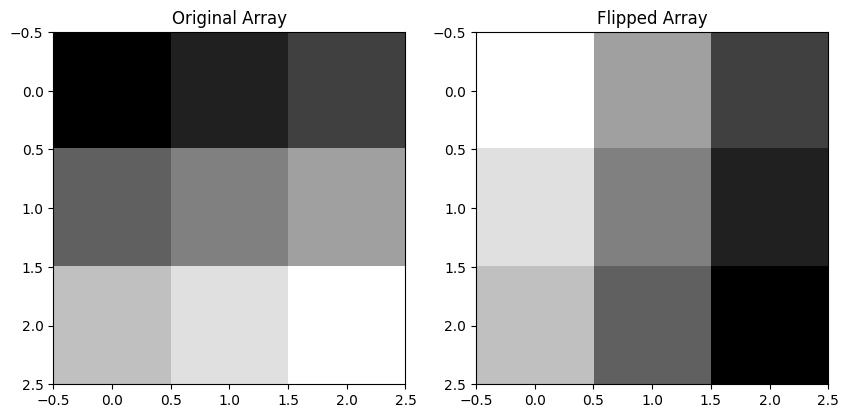

In [43]:
# Example 2D numpy array
array = np.array([[1, 2, 3],
                  [4, 5, 6],
                  [7, 8, 9]])

# Flip the array across the x=-y diagonal
flipped_array = np.flipud(np.fliplr(np.transpose(array)))
print(flipped_array)

_, ax = plt.subplots(1, 2, figsize=(10, 5))
ax[0].imshow(array, cmap='gray')
ax[0].set_title('Original Array')
ax[1].imshow(flipped_array, cmap='gray')
ax[1].set_title('Flipped Array')
plt.show()

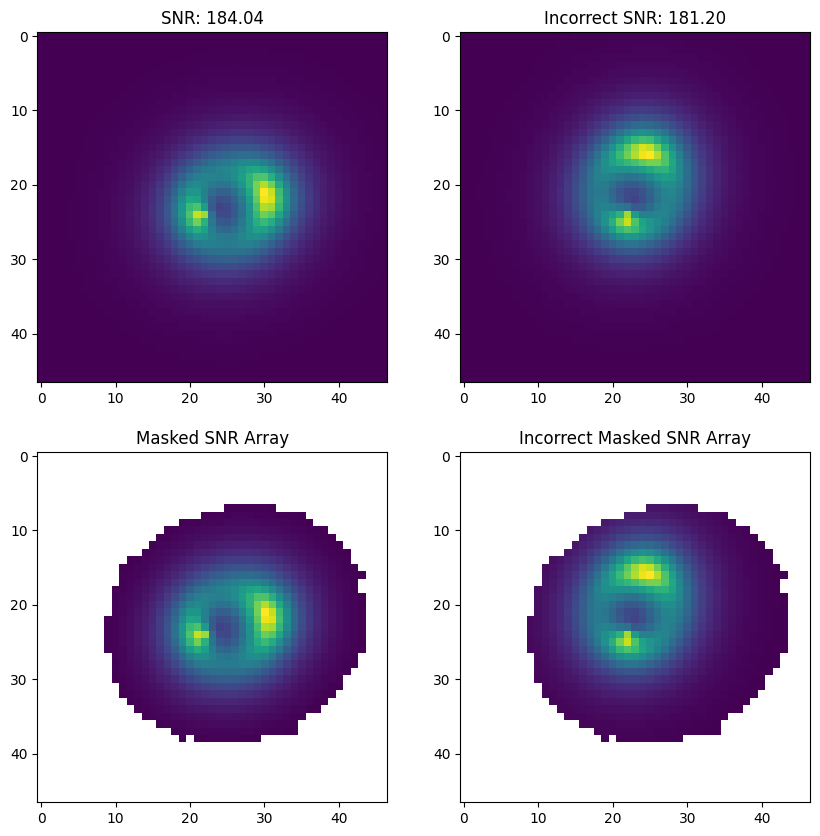

In [48]:
sample_exposure = exposures[34207]
snr, masked_snr_array, correct_exposure = get_snr(sample_exposure, bug=False)
incorrect_snr, incorrect_masked_snr_array, flipped_exposure = get_snr(sample_exposure, bug=True)

_, ax = plt.subplots(2, 2, figsize=(10, 10))
ax[0, 0].imshow(correct_exposure)
ax[0, 0].set_title(f'SNR: {snr:.2f}')
ax[1, 0].imshow(np.ma.masked_array(correct_exposure, mask=incorrect_masked_snr_array.mask))
ax[1, 0].set_title('Masked SNR Array')
ax[0, 1].imshow(flipped_exposure)
ax[0, 1].set_title(f'Incorrect SNR: {incorrect_snr:.2f}')
ax[1, 1].imshow(np.ma.masked_array(flipped_exposure, mask=incorrect_masked_snr_array.mask))
ax[1, 1].set_title('Incorrect Masked SNR Array')
plt.show()

In [45]:
correct_snrs, incorrect_snrs = [], []
for exposure in tqdm(exposures):
    # get the SNR for the original exposure
    snr, _, _ = get_snr(exposure, False)
    if snr is not None:
        correct_snrs.append(snr)

    # get the SNR for the flipped exposure
    snr_flipped, _, _ = get_snr(exposure, True)
    if snr_flipped is not None:
        incorrect_snrs.append(snr_flipped)

100%|██████████| 38838/38838 [00:06<00:00, 6251.95it/s]


In [46]:
largest_indices = np.argsort(correct_snrs)[-10:][::-1]
print(f'The indices of the largest 10 values in correct_snrs are {largest_indices}')

The indices of the largest 10 values in correct_snrs are [34207  7135  3357 16620 10734 29684 15260 24768 21466  8689]


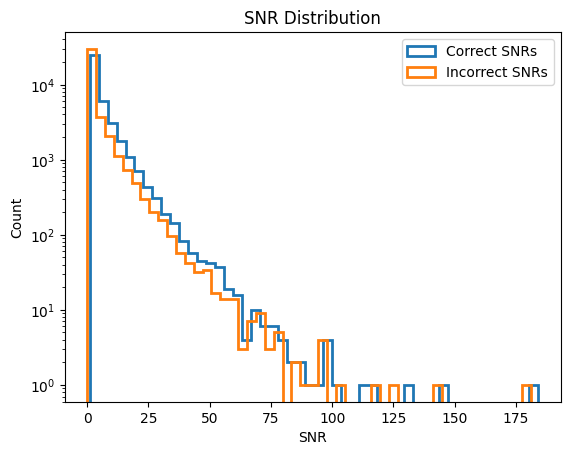

In [47]:
plt.hist(correct_snrs, histtype='step', bins=50, label='Correct SNRs', linewidth=2)
plt.hist(incorrect_snrs, histtype='step', bins=50, label='Incorrect SNRs', linewidth=2)
plt.xlabel('SNR')
plt.ylabel('Count')
plt.title('SNR Distribution')
plt.legend()
plt.yscale('log')
plt.show()